In [1]:
!python -m pip install xarray-datatree

In [2]:
import os.path
import xarray as xr
import requests
import struct
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import dask
import easygems
import easygems.healpix as egh
from scipy.interpolate import griddata
import matplotlib.colors as mcolors
import io
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import intake
from time import sleep
import shared

In [3]:
data_dir = '~/lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5'
t2m_wind_10m_path = os.path.join(data_dir, 'ERA5_monthly.1940-2025.t2m_wind10_pres.1deg.nc')
daily_1deg_88_94_path = os.path.join(data_dir, 'ERA5_daily.1988-1994.1deg.nc')
#precip_radflx_path = os.path.join(data_dir, 'ERA5_monthly.1940-2025.precip_radflx.1deg.nc')

In [ ]:
t2m_wind_10m = xr.open_dataset(t2m_wind_10m_path)
daily_1deg_88_94 = xr.open_dataset(daily_1deg_88_94_path)

elevation_data = xr.open_dataset('elevation_data/elevation_data_low_res.nc')['z']
elevation_data = elevation_data.where(elevation_data >= 0, 0)
elevation_data = xr.where(elevation_data > 0, elevation_data + 1000, 0)

t2m = t2m_wind_10m['t2m']
u10 = t2m_wind_10m['u10']
v10 = t2m_wind_10m['v10']
u10_daily = daily_1deg_88_94['u10']
v10_daily = daily_1deg_88_94['v10']
#t2m_wind_10m
#daily_1deg_88_94

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 2557, lon: 360, lat: 180)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 20kB 1988-01-01 ... 1994-12-31
  * lon         (lon) float64 3kB 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * lat         (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    u10         (valid_time, lat, lon) float32 663MB ...
    v10         (valid_time, lat, lon) float32 663MB ...
    t2m         (valid_time, lat, lon) float32 663MB ...
Attributes:
    CDI:                       Climate Data Interface version 2.4.4 (https://...
    Conventions:               CF-1.7
    institution:               European Centre for Medium-Range Weather Forec...
    GRIB_centre:               ecmf
    GRIB_centreDescription:    European Centre for Medium-Range Weather Forec...
    history:                   Thu Nov 06 03:31:21 2025: cdo -O -P 8 remapcon...
    cdo_openmp_thread_number:  8
    CDO:                       Climate Data Operators version 2.4.4 (https://...

In [14]:
cat = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

monthly_query = dict(
    variable_id=['uas','vas'],
    table_id='Amon',
    experiment_id=['historical'],
    grid_label='gn',
    member_id='r1i1p1f1'
)

monthly_cat_subset = cat.search(require_all_on=["source_id"], **monthly_query)
monthly_df = monthly_cat_subset.df
monthly_dsets = monthly_cat_subset.to_dataset_dict(
    zarr_kwargs={'consolidated': True},
    storage_options={'token': 'anon'}
)

daily_query = dict(
    variable_id=['uas','vas'],
    table_id='day',
    experiment_id=['historical'],
    grid_label='gn',
    member_id='r1i1p1f1'
)

daily_cat_subset = cat.search(require_all_on=["source_id"], **daily_query)
daily_df = daily_cat_subset.df
daily_dsets = daily_cat_subset.to_dataset_dict(
    zarr_kwargs={'consolidated': True},
    storage_options={'token': 'anon'}
)

list(daily_dsets)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.day.gn',
 'CMIP.CMCC.CMCC-ESM2.historical.day.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.day.gn',
 'CMIP.CCCR-IITM.IITM-ESM.historical.day.gn',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.day.gn',
 'CMIP.CSIRO.ACCESS-ESM1-5.historical.day.gn',
 'CMIP.BCC.BCC-CSM2-MR.historical.day.gn',
 'CMIP.CCCma.CanESM5.historical.day.gn',
 'CMIP.BCC.BCC-ESM1.historical.day.gn',
 'CMIP.NUIST.NESM3.historical.day.gn',
 'CMIP.AWI.AWI-ESM-1-1-LR.historical.day.gn',
 'CMIP.CMCC.CMCC-CM2-HR4.historical.day.gn',
 'CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.day.gn',
 'CMIP.NCC.NorCPM1.historical.day.gn',
 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.day.gn',
 'CMIP.MPI-M.ICON-ESM-LR.historical.day.gn',
 'CMIP.AWI.AWI-CM-1-1-MR.historical.day.gn',
 'CMIP.MIROC.MIROC6.historical.day.gn',
 'CMIP.CMCC.CMCC-CM2-SR5.historical.day.gn']

In [ ]:
CMIP_wind_daily = daily_dsets["CMIP.CMCC.CMCC-ESM2.historical.day.gn"].sel(time=slice("1988-01-01", "1994-12-31")).squeeze()
CMIP_v10_daily = CMIP_wind_daily['vas']
CMIP_u10_daily = CMIP_wind_daily['uas']
CMIP_u10_daily

0

In [40]:
andes = [-32, -14, 360-78, 360-62]
himalayas = [15, 55, 60, 120]

In [26]:
def get_elevation_data(elevation_data, bounds=andes):
    lat_min, lat_max, lon_min, lon_max = bounds
    
    if (elevation_data.lon > 180).any():
        elevation_data = elevation_data.assign_coords(
            lon=((elevation_data.lon + 180) % 360) - 180
        ).sortby('lon')
    
    lon_min_180 = ((lon_min + 180) % 360) - 180
    lon_max_180 = ((lon_max + 180) % 360) - 180
    
    lat_coords = elevation_data.lat.values
    lat_ascending = lat_coords[0] < lat_coords[-1]
    
    lon_span = lon_max - lon_min
    if lon_span >= 359:
        elevation = elevation_data.sel(
            lat=slice(lat_min, lat_max) if lat_ascending else slice(lat_max, lat_min)
        )
    elif lon_min_180 > lon_max_180:
        # Wrapping around dateline
        elevation = xr.concat([
            elevation_data.sel(
                lon=slice(lon_min_180, 180),
                lat=slice(lat_min, lat_max) if lat_ascending else slice(lat_max, lat_min)
            ),
            elevation_data.sel(
                lon=slice(-180, lon_max_180),
                lat=slice(lat_min, lat_max) if lat_ascending else slice(lat_max, lat_min)
            )
        ], dim='lon')
    else:
        elevation = elevation_data.sel(
            lon=slice(lon_min_180, lon_max_180),
            lat=slice(lat_min, lat_max) if lat_ascending else slice(lat_max, lat_min)
        )
    if elevation.size == 0:
        print(f"Warning: No elevation data found for bounds {bounds}")
        return None
    
    return elevation

#get_elevation_data(elevation_data)

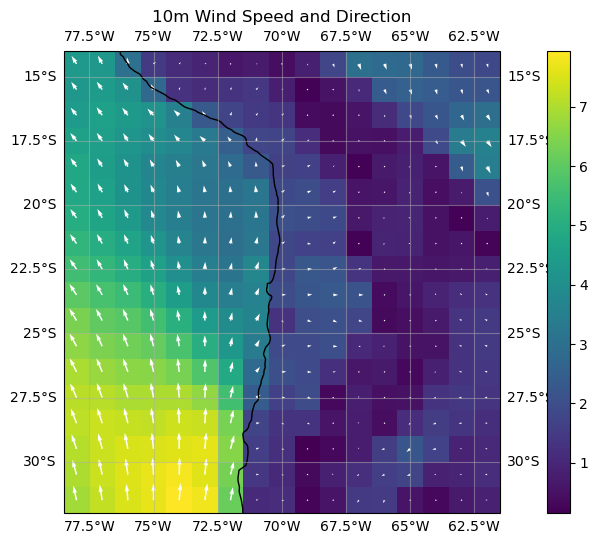

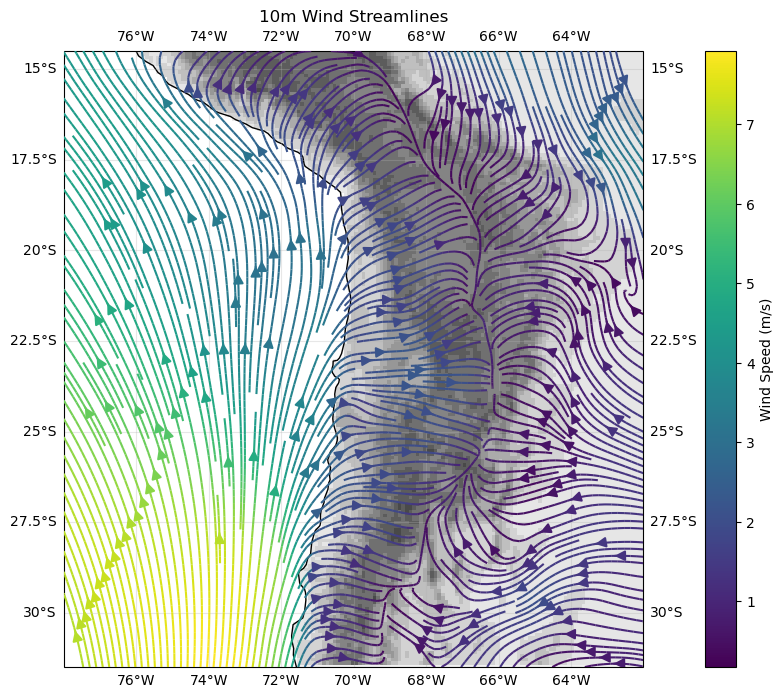

In [46]:
def mask_and_filter(ds, by_time=False, time=None, by_latlon=False, bounds=andes):
    if by_time and time is None:
        raise ValueError("If filtering by time, a timestep must be supplied (time=?)")
    lat_min, lat_max, lon_min, lon_max = bounds

    ds_out = ds

    if by_time:
        try:
            ds_out = ds.isel(valid_time=time)
        except Exception:
            ds_out = ds.isel(time=time)

    if by_latlon:
        where_clause = (ds_out.lat >= lat_min) & (ds_out.lat <= lat_max) & (ds_out.lon >= lon_min) & (ds_out.lon <= lon_max)
        ds_out = ds_out.where(where_clause, drop=True)
    
    return ds_out

def wind_speed_map(u10_single_timestep, v10_single_timestep, skip=1, show=True):
    wind_speed = (u10_single_timestep**2 + v10_single_timestep**2)**0.5

    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Plot wind speed as background
    wind_speed.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=True)

    # Overlay wind vectors
    u_sub = u10_single_timestep[::skip, ::skip]
    v_sub = v10_single_timestep[::skip, ::skip]

    ax.quiver(
        u_sub.lon, u_sub.lat,
        u_sub.values, v_sub.values,
        transform=ccrs.PlateCarree(),
        color='white',
        scale=200
    )

    ax.coastlines()
    ax.gridlines(draw_labels=True, alpha=0.5)
    ax.set_title('10m Wind Speed and Direction')

    if show:    
        plt.show()   
    return fig, ax

def wind_stream_plot(
        u10_single_timestep, 
        v10_single_timestep, 
        show=True, density=2, 
        colorbar_limits = [None, None], 
        add_date_to_title=False,
        figsize=(12, 6),
        linewidth=1.5,
        arrowsize=1.5,
        elevation_data=None
    ):

    lons = u10_single_timestep.lon.values
    lats = u10_single_timestep.lat.values
    u_data = u10_single_timestep.values
    v_data = v10_single_timestep.values

    # Flip latitude if descending
    if lats[0] > lats[-1]:
        lats = lats[::-1]
        u_data = np.flip(u_data, axis=0)
        v_data = np.flip(v_data, axis=0)

    lons_display = np.where(lons > 180, lons - 360, lons)

    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})

    if elevation_data is not None:
        try:
            elevation_data_filtered = get_elevation_data(
                elevation_data, 
                bounds=[np.min(lats), np.max(lats), np.min(lons), np.max(lons)]
            )
            
            if elevation_data_filtered is not None:
                elev_values = elevation_data_filtered.values
                elev_lons = elevation_data_filtered.lon.values
                elev_lats = elevation_data_filtered.lat.values
                elev_min, elev_max = np.nanmin(elev_values), np.nanmax(elev_values)
                elev_normalized = (elev_values - elev_min) / (elev_max - elev_min)
                
                greys = LinearSegmentedColormap.from_list('terrain_grey', ['#ffffff','#000000'], N=10)
                
                ax.imshow(
                    elev_normalized,
                    extent=[elev_lons.min(), elev_lons.max(), elev_lats.min(), elev_lats.max()],
                    origin='lower',
                    cmap=greys,
                    alpha=0.7,
                    zorder=0,
                    transform=ccrs.PlateCarree()
                )
        except Exception as e:
            print(f"Could not add elevation data: {e}")
            import traceback
            traceback.print_exc()

    ax.coastlines(resolution='50m')
    #ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.LAND, facecolor='lightgray', alpha=0.3)

    ax.set_extent([lons_display.min(), lons_display.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())

    magnitude = np.sqrt(u_data**2 + v_data**2)

    vmin, vmax = colorbar_limits
    magnitude_clipped = magnitude.copy()
    if vmin is not None:
        magnitude_clipped = np.maximum(magnitude_clipped, vmin)
    if vmax is not None:
        magnitude_clipped = np.minimum(magnitude_clipped, vmax)

    streamplot = ax.streamplot(
        lons_display, lats,
        u_data, v_data,
        density=density,
        color=magnitude_clipped, 
        linewidth=linewidth,
        arrowsize=arrowsize,
        cmap='viridis',
        zorder=3
    )

    cbar = fig.colorbar(streamplot.lines, ax=ax, label='Wind Speed (m/s)')
    if vmin is not None or vmax is not None:
        cbar.mappable.set_clim(vmin=vmin, vmax=vmax)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.gridlines(draw_labels=True, alpha=0.3)
    ax.set_title('10m Wind Streamlines')
    try:
        if add_date_to_title:
            ax.set_title(f'10m Wind Streamlines - {np.datetime_as_string(u10_single_timestep.valid_time.values, unit="D")}')
    except Exception:
        if add_date_to_title:
            ax.set_title(f'10m Wind Streamlines - {np.datetime_as_string(u10_single_timestep.time.values, unit="D")}')

    if show:
        plt.show()
    return fig, ax

u10_single_timestep = mask_and_filter(u10, by_time=True, time=0, by_latlon=True, bounds=andes)
v10_single_timestep = mask_and_filter(v10, by_time=True, time=0, by_latlon=True, bounds=andes)

wind_speed_map(u10_single_timestep, v10_single_timestep)
_ = wind_stream_plot(u10_single_timestep, v10_single_timestep, elevation_data=elevation_data, density=3, figsize=(16, 8))

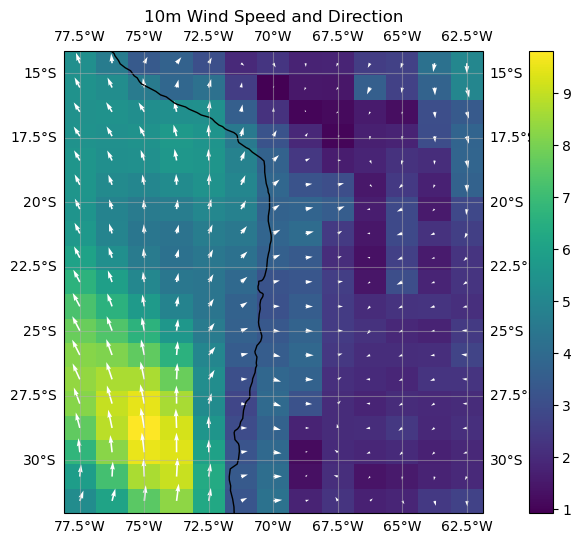

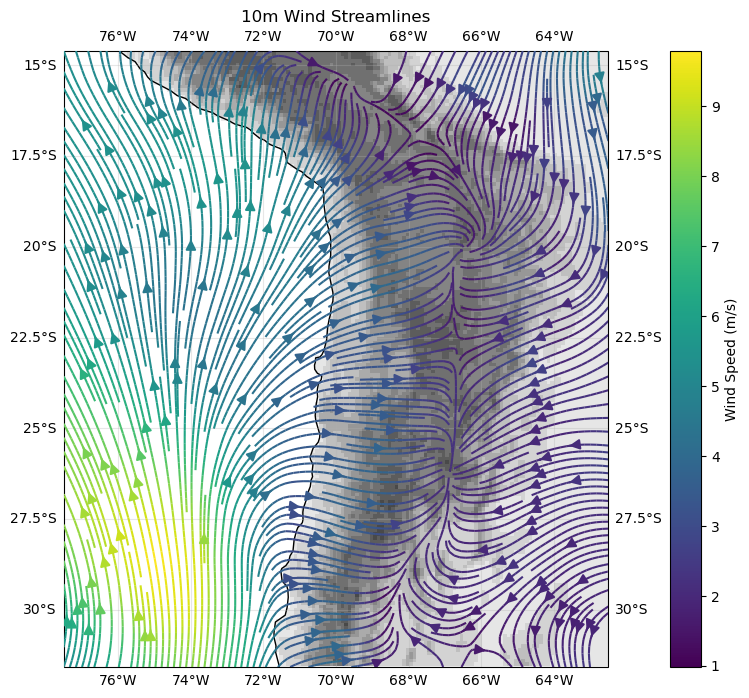

In [43]:
CMIP_u10_single_timestep = mask_and_filter(CMIP_u10_daily, by_time=True, time=0, by_latlon=True, bounds=andes)
CMIP_v10_single_timestep = mask_and_filter(CMIP_v10_daily, by_time=True, time=0, by_latlon=True, bounds=andes)

wind_speed_map(CMIP_u10_single_timestep, CMIP_v10_single_timestep)
_ = wind_stream_plot(CMIP_u10_single_timestep, CMIP_v10_single_timestep, elevation_data=elevation_data, density=3, figsize=(16, 8))

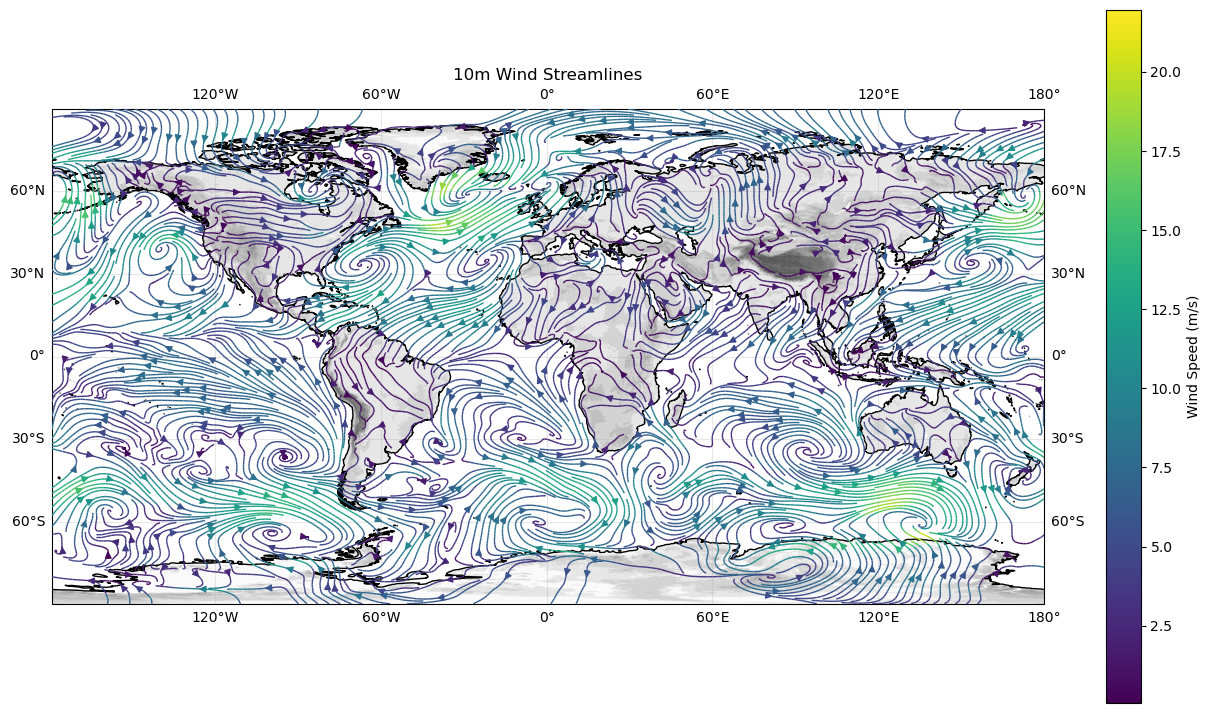

In [8]:
u10_daily_single_timestep = mask_and_filter(u10_daily, by_time=True, time=0, by_latlon=False)
v10_daily_single_timestep = mask_and_filter(v10_daily, by_time=True, time=0, by_latlon=False)

#_ = wind_speed_map(u10_daily_single_timestep, v10_daily_single_timestep)
_ = wind_stream_plot(u10_daily_single_timestep, v10_daily_single_timestep, density=6, figsize=(16,9), linewidth=1.0, arrowsize=1.0, elevation_data=elevation_data)

In [ ]:
num_months = 24
duration = 500

frames = []

for i in range (0):
    u10_single_timestep = mask_and_filter(u10, by_time=True, time=i, by_latlon=True)
    v10_single_timestep = mask_and_filter(v10, by_time=True, time=i, by_latlon=True)

    fig, ax = wind_stream_plot(u10_single_timestep, v10_single_timestep, show=False, colorbar_limits=[0, 12], add_date_to_title=True)

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)

    frames.append(Image.open(buf))

output_gif_path = f"first_{num_months}_months_wind_field.gif"
frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], duration=duration, loop=0)

print(f"Animation saved as {output_gif_path}")

TypeError: input must have type NumPy datetime

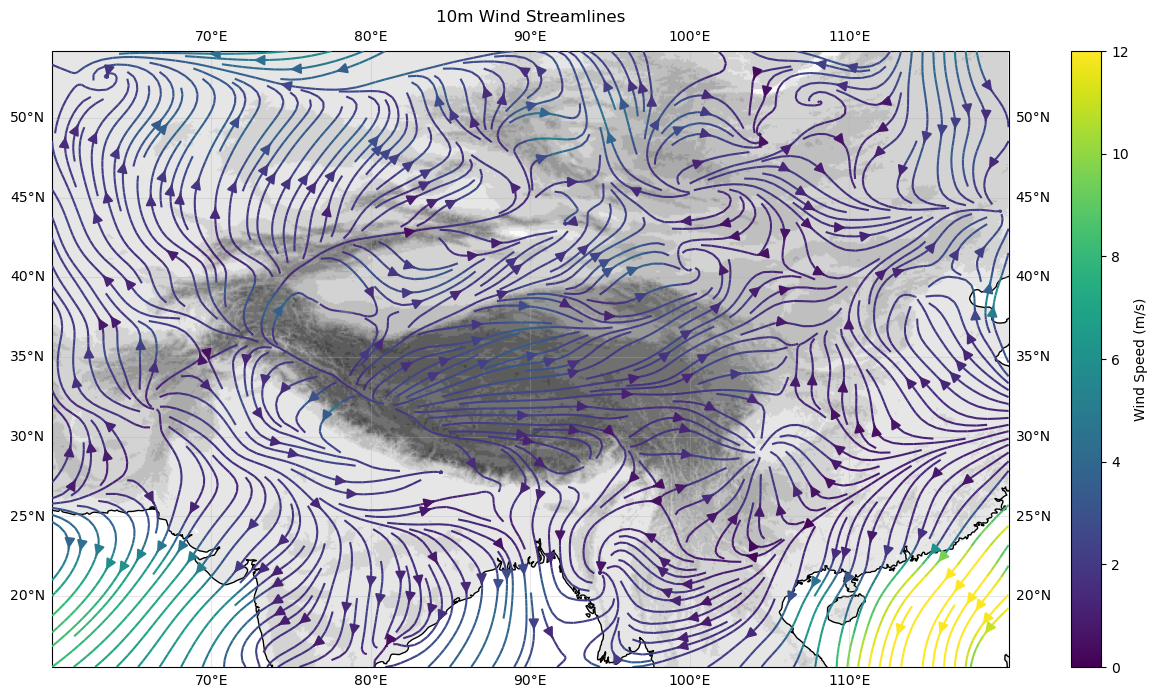

In [47]:
num_days = 365
duration = 500

frames = []
frame_dir = 'frames'

if not os.path.exists(frame_dir):
    os.mkdir(frame_dir)

for i in range(num_days):
    frame_path = f"{frame_dir}/{i}.png"
    if os.path.exists(frame_path):
        continue
    
    u10_single_day = mask_and_filter(CMIP_u10_daily, by_time=True, time=i, by_latlon=True, bounds=himalayas)
    v10_single_day = mask_and_filter(CMIP_v10_daily, by_time=True, time=i, by_latlon=True, bounds=himalayas)

    fig, ax = wind_stream_plot(u10_single_day, v10_single_day, show=False, colorbar_limits=[0, 12], add_date_to_title=True, density=3, figsize=(16,8), linewidth=1.5, arrowsize=1.5, elevation_data=elevation_data)

    plt.savefig(frame_path, format='png')
    plt.close(fig)

    
for i in range(num_days):
    frame_path = f"{frame_dir}/{i}.png"
    frames.append(Image.open(frame_path))


output_gif_path = f"CMIP_first_{num_days}_days_wind_field_himalayas.gif"
frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], duration=duration, loop=0)


for f in frames:
    f.close()
for name in os.listdir(frame_dir):
    object_path = os.path.join(frame_dir, name)
    if os.path.isfile(object_path):
        os.remove(object_path)
os.rmdir(frame_dir)

print(f"Animation saved as {output_gif_path}")